In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt 

In [4]:
import time

def tic():
    global start_time
    start_time = time.time()

def toc():
    if 'start_time' in globals():
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time} seconds")
    else:
        print("Tic function has not been called yet.")

# Antithetic Variates 

## Underlying principle 

If we want to estimate $\theta = \mathbb{E}(h(X)) = \mathbb{E}(Y)$ and we have two samples $Y_{1}, Y_{2}$:

$\hat{\theta} = \frac{Y_{1}+Y_{2}}{2}$ 

$Var(\hat{\theta}) = \frac{Var(Y_{1})+Var(Y_{2})+2Cov(Y_{1},Y_{2})}{4}$

Hence, variance is reduced if $Cov(Y_{1},Y_{2})$ is negative. 

When the price volatility of two assets are identical, variance is maximally reduced: 

$dS_{1,t} = rdS_{1,t}dt + \sigma dS_{1,t}dz_{t}$

$dS_{2,t} = rdS_{2,t}dt - \sigma dS_{2,t}dz_{t}$

## Implementation 

We create a hypothetical asset which is perfectly negatively correlated with the original asset, giving us the following: 

$S_{t+\Delta t} = S_{t} e^{v\Delta t + \sigma(z_{t+\Delta t} - z_{t})}$, where $(z_{t+\Delta t} - z{t}) \sim N(0,\Delta t) \sim \sqrt{\Delta t}N(0,1)\sim\sqrt{\Delta t}\epsilon_{i}$

### Contract Simulation 

- $C_{T,i} = \max{(0, Se^{v\Delta t + \sigma\sqrt{T}(\epsilon_{i})}-K)}$

- $C_{T,i} = \max{(0, Se^{v\Delta t + \sigma\sqrt{T}(-\epsilon_{i})}-K)}$

In [16]:
S = 101.15 # stock price
K = 98.01 # strike price
vol = 0.0991 # volatility (%)
r = 0.015 # risk-free rate (%)
N = 10 # number of time steps 
M = 100 # number of simulations

market_value = 3.86 # market price of the option 
T = ((datetime.date(2024,3,17) - datetime.date(2024,1,17)).days+1)/365 # time in years
print(T)

0.16712328767123288


## Slow solution

In [17]:
tic()
# Precomputing constants 
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error parameters
sum_CT = 0
sum_CT2 = 0

# MC method 
for i in range(M):
    lnSt1 = lnS
    lnSt2 = lnS
    for j in range(N):
        epsilon = np.random.normal()
        lnSt1 = lnSt1 + nudt + volsdt*epsilon
        lnSt2 = lnSt2 + nudt - volsdt*epsilon
        
    ST1 = np.exp(lnSt1)
    ST2 = np.exp(lnSt2)
    CT = 0.5 * (max(0, ST1 - K) + max(0, ST2 - K))
    sum_CT += CT
    sum_CT2 += CT**2
    
# Computing expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt((sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1))
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
time.sleep(2)
toc()

Call value is $3.83 with SE +/- 0.09
Elapsed time: 2.0061419010162354 seconds


## Vectorization for fast solution 

In [18]:
tic()
# Precomputing constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# MC Method
Z = np.random.normal(size=(N, M))
delta_lnSt1 = nudt + volsdt*Z
delta_lnSt2 = nudt - volsdt*Z
lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)

# Computing Expectation and SE
ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)
CT = 0.5 * ( np.maximum(0, ST1[-1] - K) + np.maximum(0, ST2[-1] - K) )
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
time.sleep(2)
toc()

Call value is $3.91 with SE +/- 0.09
Elapsed time: 2.0052847862243652 seconds


### Comparison without Antithetic Variate

In [19]:
tic()
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0w = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SEw = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
time.sleep(2)
toc()

Call value is $3.91 with SE +/- 0.09
Elapsed time: 2.0057270526885986 seconds


## Visualization of convergence

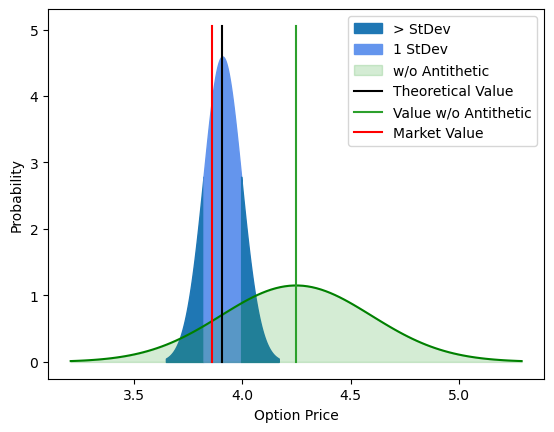

In [20]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green',
        label='Value w/o Antithetic')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()